# Classifaing both Alzheimer's and Brain Tumor 

I will build step by step model to evaluate the MRI Images and find Alzheimer's disease severity, type of Brain tumor on no disease

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
import pandas as pd

from tensorflow.keras.layers import Dense, Dropout,Flatten, GlobalAveragePooling2D 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetV2S, resnet50

from sklearn.model_selection import train_test_split

import functions

# For reproducibility
np.random.seed(18)

### Functions

In [2]:
def load_img_from_dir_cat(path):
    '''
    '''
    X = []
    y = []

    for num_label, label in enumerate(listdir(path)):
        # Skip No disease folders
        if label in ('NonDemented', 'no_tumor'):
            continue
        else:
            # Change each image and append to X and y
            for image_file in listdir(f'{path}/{label}'):
                 if '.jpg' in image_file:
                    # target_size automatically resizes each img on import
                    image = load_img(f'{path}/{label}/{image_file}', target_size=(image_size, image_size))
                    image = img_to_array(image) / 255
                    X.append(image)
                    if num_label == 3:
                        num_label = 2
                    y.append(num_label) 
                    # For training the model
    if 'train' in path:
        X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=18, stratify=y) 
        
        # Change for TensorFlow models
        X_train = np.array(X_train, dtype='float32')
        X_val = np.array(X_val, dtype='float32')

        y_train = to_categorical(y_train, num_classes=3, dtype='float32')
        y_val = to_categorical(y_val, num_classes=3, dtype='float32')

        return X_train, X_val, y_train, y_val
    # For testing
    else:
        X_test = np.array(X, dtype='float32')
        y_test = to_categorical(y, num_classes=3, dtype='float32')
        return X_test, y_test

In [3]:
def load_img_from_dir_binary(path):
    '''
    '''
    X = []
    y = []

    for label in listdir(path):
        # Change each image and append to X and y
        for image_file in listdir(f'{path}/{label}'):
             if '.jpg' in image_file:
                # target_size automatically resizes each img on import
                image = load_img(f'{path}/{label}/{image_file}', target_size=(image_size, image_size))
                image = img_to_array(image) / 255
                X.append(image)
                if label in ('NonDemented', 'no_tumor'):
                    y.append(0)
                else:
                    y.append(1)
    return X, y

In [4]:
def al_bt_load_img_from_dir_binary(path):
    '''
    '''
    X = []
    y = []

    for label in listdir(path):
        # Skip No disease folders
        if label not in ('NonDemented', 'no_tumor'):
            # Change each image and append to X and y
            for image_file in listdir(f'{path}/{label}'):
                 if '.jpg' in image_file:
                    # target_size automatically resizes each img on import
                    image = load_img(f'{path}/{label}/{image_file}', target_size=(image_size, image_size))
                    image = img_to_array(image) / 255
                    X.append(image)
                    if 'alzheimer' in path:
                        y.append(0)
                    else:
                        y.append(1)
    return X, y

In [5]:
def combine_images_from_two_path_binary(path1, path2, function = load_img_from_dir_binary):
    X_1, y_1 = function(path1)
    X_2, y_2 = function(path2)
    
    X = X_1 + X_2
    y = y_1 + y_2
    if 'train' in path1:
        X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=18, stratify=y) 
        X_train = np.array(X_train, dtype='float32')
        X_val = np.array(X_val, dtype='float32')
        y_train = np.array(y_train, dtype='float32')
        y_val = np.array(y_val, dtype='float32')
        return X_train, X_val, y_train, y_val
    else:
        X_test = np.array(X, dtype='float32')
        y_test = np.array(y, dtype='float32')
        return X_test, y_test

In [6]:
# Set image size
image_size = 240

# Set Early stopping
es = EarlyStopping(patience = 5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [7]:
# Path to Alzheimer's data
al_path_train = '../data/alzheimer/train'
al_path_test = '../data/alzheimer/test'

# Path to Brain Tumor data
bt_path_train = '../data/brain_tumor/train'
bt_path_test = '../data/brain_tumor/test'

## Make Binary data Disease - No disease
Combine datasets and make binary data - disease - 1, no disease - 0

In [8]:
X_train, X_val, y_train, y_val = combine_images_from_two_path_binary(al_path_train, bt_path_train)
X_train.shape, y_train.shape

((5993, 240, 240, 3), (5993,))

In [9]:
X_test, y_test = combine_images_from_two_path_binary(al_path_test, bt_path_test)

In [21]:
effnet_bi = EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classes=2,
    classifier_activation="sigmoid",
    include_preprocessing=True,
)


# Freeze last 5 layers
for layer in effnet_bi.layers[:-5]:
    layer.trainable = False

In [22]:
model = Sequential()

model.add(effnet_bi)
model.add(GlobalAveragePooling2D())
#model.add(Dropout(.2))

#Just use a single output layer
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

h = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
188/188 [==============================] - 755s 4s/step - loss: 0.5594 - accuracy: 0.6696 - val_loss: 0.5424 - val_accuracy: 0.6802 - lr: 0.0010
Epoch 2/30
188/188 [==============================] - 664s 4s/step - loss: 0.5133 - accuracy: 0.7158 - val_loss: 0.4953 - val_accuracy: 0.7508 - lr: 0.0010
Epoch 3/30
188/188 [==============================] - 662s 4s/step - loss: 0.4935 - accuracy: 0.7324 - val_loss: 0.4885 - val_accuracy: 0.7467 - lr: 0.0010
Epoch 4/30
188/188 [==============================] - 594s 3s/step - loss: 0.4808 - accuracy: 0.7460 - val_loss: 0.4542 - val_accuracy: 0.7708 - lr: 0.0010
Epoch 5/30
188/188 [==============================] - 593s 3s/step - loss: 0.4707 - accuracy: 0.7472 - val_loss: 0.4446 - val_accuracy: 0.7903 - lr: 0.0010
Epoch 6/30
188/188 [==============================] - 608s 3s/step - loss: 0.4674 - accuracy: 0.7567 - val_loss: 0.4407 - val_accuracy: 0.7848 - lr: 0.0010
Epoch 7/30
188/188 [==============================] - 592s 3s/st

Accuracy_score: 0.6653 



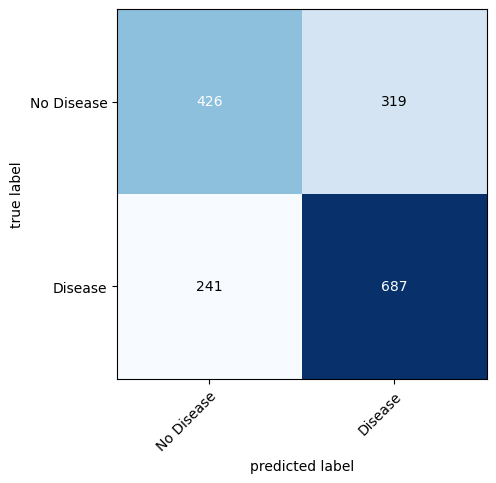

In [23]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model, X=X_test, y=y_test, class_names_list =  ['No Disease', 'Disease'], binary = True)

In [34]:
rn_model_bi = resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classifier_activation="sigmoid"
)

In [35]:
for layer in rn_model_bi.layers:
    layer.trainable = False

In [36]:

model = Sequential()

model.add(rn_model_bi)
model.add(Flatten())

#Just use a single output layer
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

h = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
188/188 [==============================] - 280s 1s/step - loss: 0.6934 - accuracy: 0.7053 - val_loss: 0.4358 - val_accuracy: 0.8013 - lr: 0.0010
Epoch 2/30
188/188 [==============================] - 272s 1s/step - loss: 0.6041 - accuracy: 0.7375 - val_loss: 0.7048 - val_accuracy: 0.6742 - lr: 0.0010
Epoch 3/30
188/188 [==============================] - 273s 1s/step - loss: 0.5689 - accuracy: 0.7519 - val_loss: 0.8924 - val_accuracy: 0.6647 - lr: 0.0010
Epoch 4/30
188/188 [==============================] - 278s 1s/step - loss: 0.5093 - accuracy: 0.7769 - val_loss: 0.7176 - val_accuracy: 0.7032 - lr: 0.0010
Epoch 5/30
188/188 [==============================] - 277s 1s/step - loss: 0.5240 - accuracy: 0.7757 - val_loss: 0.4525 - val_accuracy: 0.7818 - lr: 0.0010
Epoch 6/30
188/188 [==============================] - 277s 1s/step - loss: 0.4201 - accuracy: 0.8061 - val_loss: 0.3671 - val_accuracy: 0.8208 - lr: 0.0010
Epoch 7/30
188/188 [==============================] - 273s 1s/st

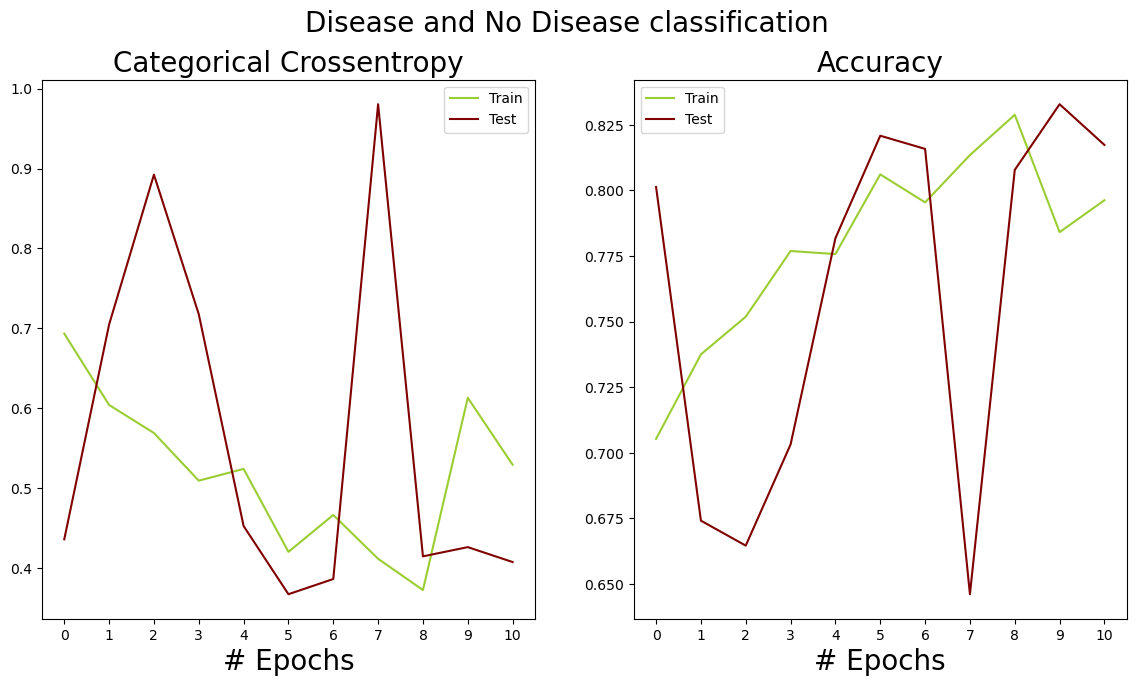

In [37]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h, 'Disease and No Disease classification')

Accuracy_score: 0.8208 



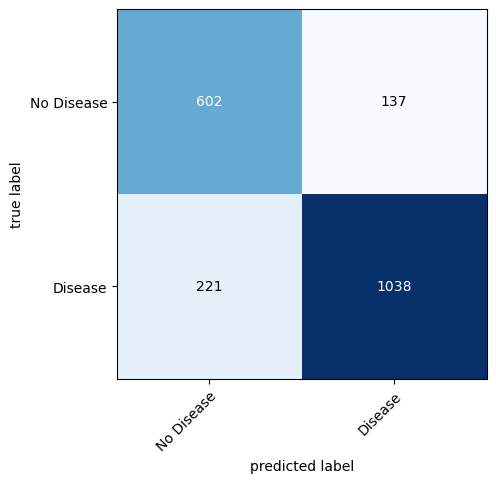

In [38]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model, X=X_val, y=y_val, class_names_list =  ['No Disease', 'Disease'], binary = True)

Accuracy_score: 0.6958 



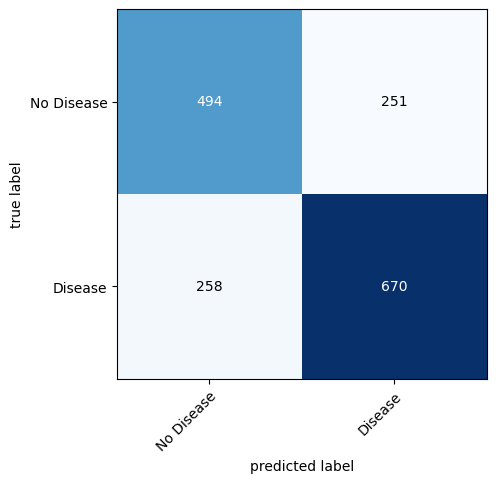

In [39]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model, X=X_test, y=y_test, class_names_list =  ['No Disease', 'Disease'], binary = True)

In [71]:
model.save('../models/disease_no_diseae.hdf5')

Tryied Conv2D - 2,2, different oprimizers, , remove strides (, strides = (2,2) in max pooling), removing droupout, 



To try:
different Conv2d params
32 - all, different numbers as in bt

adding l2 regularizetion,  batch_size 32, 64, 


pool_size 3,3


Increace droupout

Remove - add one conv layer
Remove - add  one connected layer


In [110]:
model = Sequential()

model.add(layers.Input(shape=(image_size, image_size, 3)))

#First Convolution
model.add(Conv2D(64, (3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Second Convolution
model.add(Conv2D(64, (3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Third Convolution
model.add(Conv2D(128, (3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Fourth Convolution
model.add(Conv2D(256, (3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Fifth Convolution
model.add(Conv2D(512, (3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Flatten
model.add(Flatten())
# Fully Connected

model.add(Dense(256, activation="relu", kernel_regularizer=l2(0.005))) 

model.add(Dense(128, activation="relu", kernel_regularizer=l2(0.005))) # next try 0.0005

model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

h = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, callbacks = [es, reduce_lr])

Epoch 1/50
188/188 [==============================] - 358s 2s/step - loss: 0.9174 - accuracy: 0.6297 - val_loss: 0.5645 - val_accuracy: 0.6301 - lr: 0.0010
Epoch 2/50
188/188 [==============================] - 349s 2s/step - loss: 0.5487 - accuracy: 0.6322 - val_loss: 0.5384 - val_accuracy: 0.6431 - lr: 0.0010
Epoch 3/50
188/188 [==============================] - 347s 2s/step - loss: 0.5364 - accuracy: 0.6424 - val_loss: 0.5297 - val_accuracy: 0.6306 - lr: 0.0010
Epoch 4/50
188/188 [==============================] - 345s 2s/step - loss: 0.5290 - accuracy: 0.6566 - val_loss: 0.5179 - val_accuracy: 0.7327 - lr: 0.0010
Epoch 5/50
188/188 [==============================] - 345s 2s/step - loss: 0.5174 - accuracy: 0.7100 - val_loss: 0.4720 - val_accuracy: 0.7648 - lr: 0.0010
Epoch 6/50
188/188 [==============================] - 342s 2s/step - loss: 0.4946 - accuracy: 0.7382 - val_loss: 0.4659 - val_accuracy: 0.7653 - lr: 0.0010
Epoch 7/50
188/188 [==============================] - 344s 2s/st

Accuracy_score: 0.7352 



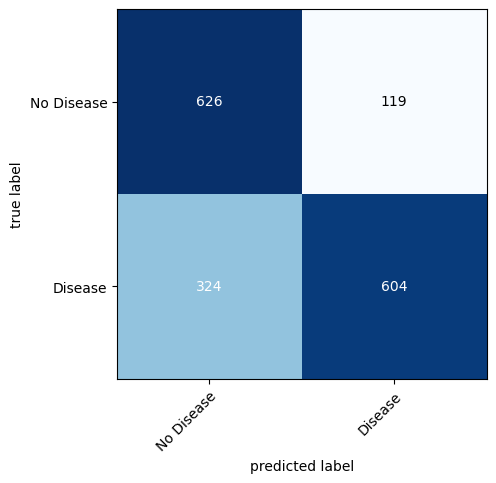

In [111]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model, X=X_test, y=y_test, class_names_list =  ['No Disease', 'Disease'], binary = True)

# The best so Far

In [120]:
model = Sequential()

model.add(layers.Input(shape=(image_size, image_size, 1)))

#First Convolution
model.add(Conv2D(64, (3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Second Convolution
model.add(Conv2D(64, (3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Third Convolution
model.add(Conv2D(128, (3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Fourth Convolution
model.add(Conv2D(256, (3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Fifth Convolution
model.add(Conv2D(512, (3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Flatten
model.add(Flatten())
# Fully Connected

model.add(Dense(256, activation="relu", kernel_regularizer=l2(0.005))) 

model.add(Dense(128, activation="relu", kernel_regularizer=l2(0.005))) # next try 0.0005

model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

h = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, callbacks = [es, reduce_lr])

Epoch 1/50
188/188 [==============================] - 290s 2s/step - loss: 0.8997 - accuracy: 0.6873 - val_loss: 0.6398 - val_accuracy: 0.7513 - lr: 0.0010
Epoch 2/50
188/188 [==============================] - 332s 2s/step - loss: 0.5454 - accuracy: 0.7394 - val_loss: 0.4970 - val_accuracy: 0.7668 - lr: 0.0010
Epoch 3/50
188/188 [==============================] - 334s 2s/step - loss: 0.4895 - accuracy: 0.7647 - val_loss: 0.4755 - val_accuracy: 0.7813 - lr: 0.0010
Epoch 4/50
188/188 [==============================] - 334s 2s/step - loss: 0.4637 - accuracy: 0.7802 - val_loss: 0.4483 - val_accuracy: 0.8028 - lr: 0.0010
Epoch 5/50
188/188 [==============================] - 331s 2s/step - loss: 0.4243 - accuracy: 0.7978 - val_loss: 0.4083 - val_accuracy: 0.8183 - lr: 0.0010
Epoch 6/50
188/188 [==============================] - 341s 2s/step - loss: 0.3881 - accuracy: 0.8276 - val_loss: 0.4497 - val_accuracy: 0.8043 - lr: 0.0010
Epoch 7/50
188/188 [==============================] - 295s 2s/st

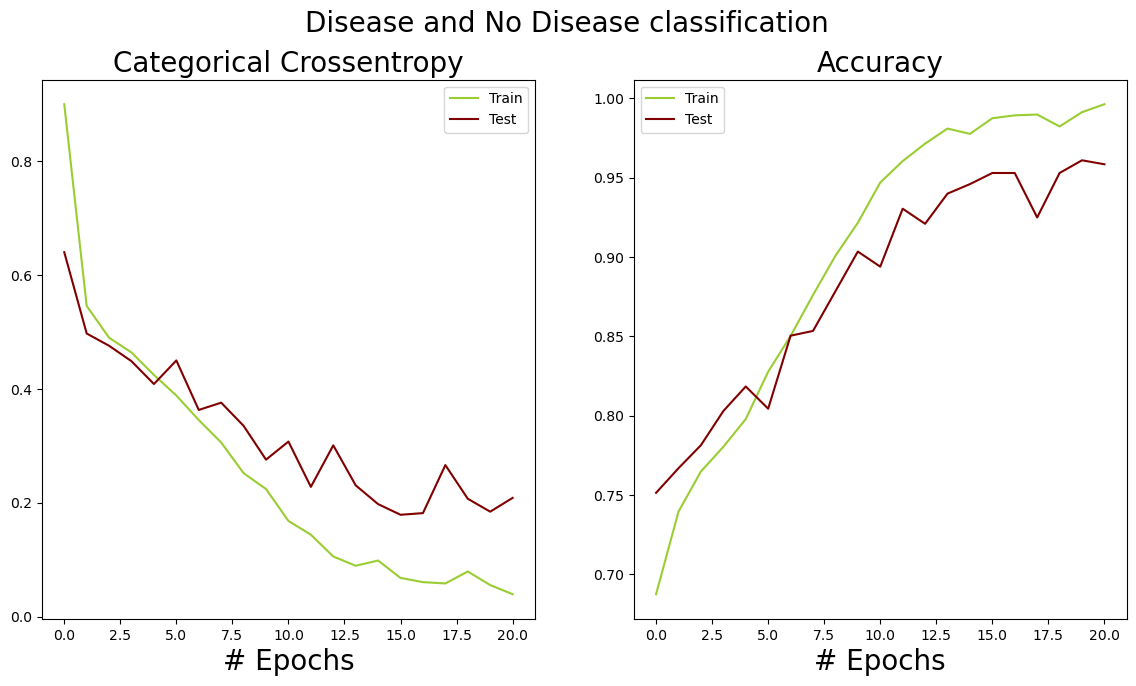

In [123]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h, 'Disease and No Disease classification')

Accuracy_score: 0.953 



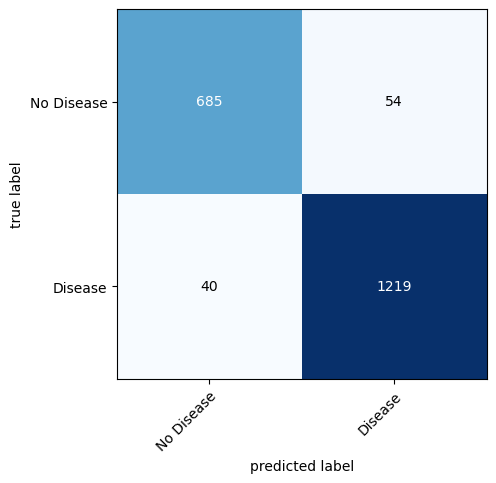

In [122]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model, X=X_val, y=y_val, class_names_list =  ['No Disease', 'Disease'], binary = True)

Accuracy_score: 0.7442 



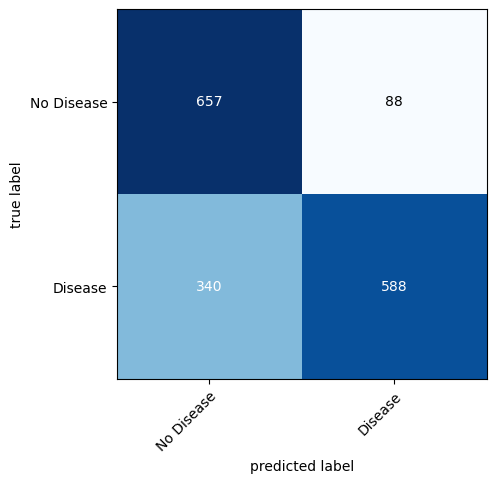

In [121]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model, X=X_test, y=y_test, class_names_list =  ['No Disease', 'Disease'], binary = True)

## Make Binary data Alzheimer's - Brain tumor
Combine datasets, ignoring No disease images and make binary data - Alzheimer's  - 0, Brain tumor - 1

In [53]:
X_train_al_bt, X_val_al_bt, y_train_al_bt, y_val_al_bt = combine_images_from_two_path_binary(al_path_train, bt_path_train, function = al_bt_load_img_from_dir_binary)
X_train_al_bt.shape, y_train_al_bt.shape

((3777, 240, 240, 3), (3777,))

In [54]:
X_test_al_bt, y_test_al_bt = combine_images_from_two_path_binary(al_path_test, bt_path_test, function = al_bt_load_img_from_dir_binary)

In [55]:
effnet_bi = EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classifier_activation="sigmoid",
    include_preprocessing=True,
)


# Freeze last 5 layers
for layer in effnet_bi.layers[:-5]:
    layer.trainable = False

In [56]:
model_al_bt = Sequential()

model_al_bt.add(effnet_bi)
model_al_bt.add(GlobalAveragePooling2D())


#Just use a single output layer
model_al_bt.add(Dense(1, activation='sigmoid'))

# Compile
model_al_bt.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

h_al_bt = model_al_bt.fit(X_train_al_bt, y_train_al_bt, validation_data = (X_val_al_bt, y_val_al_bt), epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
119/119 [==============================] - 243s 2s/step - loss: 0.1225 - accuracy: 0.9550 - val_loss: 0.0294 - val_accuracy: 0.9889 - lr: 0.0010
Epoch 2/30
119/119 [==============================] - 251s 2s/step - loss: 0.0528 - accuracy: 0.9780 - val_loss: 0.0142 - val_accuracy: 0.9952 - lr: 0.0010
Epoch 3/30
119/119 [==============================] - 234s 2s/step - loss: 0.0370 - accuracy: 0.9860 - val_loss: 0.0130 - val_accuracy: 0.9952 - lr: 0.0010
Epoch 4/30
119/119 [==============================] - 225s 2s/step - loss: 0.0346 - accuracy: 0.9860 - val_loss: 0.0073 - val_accuracy: 0.9968 - lr: 0.0010
Epoch 5/30
119/119 [==============================] - 231s 2s/step - loss: 0.0349 - accuracy: 0.9846 - val_loss: 0.0096 - val_accuracy: 0.9968 - lr: 0.0010
Epoch 6/30
119/119 [==============================] - 225s 2s/step - loss: 0.0331 - accuracy: 0.9860 - val_loss: 0.0086 - val_accuracy: 0.9968 - lr: 0.0010
Epoch 7/30
119/119 [==============================] - 223s 2s/st

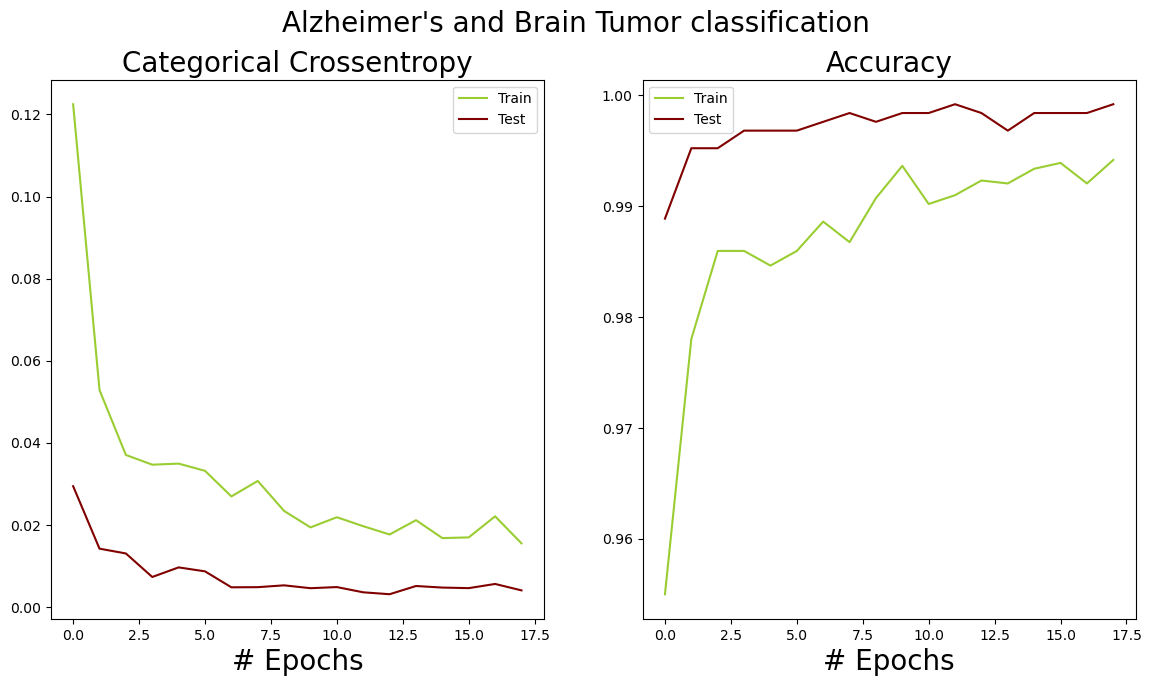

In [57]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_al_bt, 'Alzheimer\'s and Brain Tumor classification')

Accuracy_score: 0.9984 



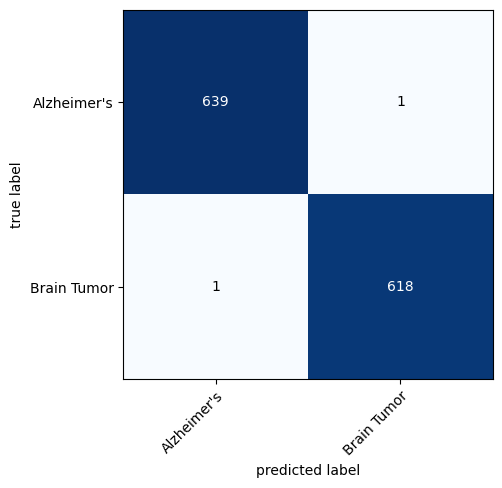

In [58]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_al_bt, X=X_val_al_bt, y=y_val_al_bt, class_names_list =  ['Alzheimer\'s', 'Brain Tumor'], binary = True)

Accuracy_score: 0.9989 



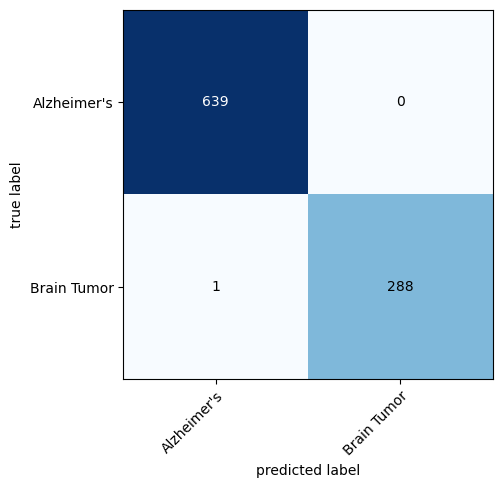

In [59]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_al_bt, X=X_test_al_bt, y=y_test_al_bt, class_names_list =  ['Alzheimer\'s', 'Brain Tumor'], binary = True)

In [72]:
model_al_bt.save('../models/al_bt.hdf5')

## Predict Sevetiry of Alzeimer's or Type of Brain Tumor

### Sevetiry of Alzeimer's

In [60]:
X_train_al, X_val_al, y_train_al, y_val_al = load_img_from_dir_cat(al_path_train)
X_train_al.shape, y_train_al.shape

((1920, 240, 240, 3), (1920, 3))

In [61]:
X_test_al, y_test_al = load_img_from_dir_cat(al_path_test)

In [62]:
rn_model = resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classes=3,
    classifier_activation="softmax"
)

In [63]:
for layer in rn_model.layers:
    layer.trainable = False

In [64]:
model_al = Sequential()

model_al.add(rn_model)
model_al.add(Flatten())

#Just use a single output layer
model_al.add(Dense(3, activation='softmax'))

# Compile
model_al.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_al = model_al.fit(X_train_al, y_train_al, validation_data = (X_val_al, y_val_al), epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
60/60 [==============================] - 90s 1s/step - loss: 5.2683 - accuracy: 0.5714 - val_loss: 2.1777 - val_accuracy: 0.7005 - lr: 0.0010
Epoch 2/30
60/60 [==============================] - 88s 1s/step - loss: 0.8614 - accuracy: 0.6969 - val_loss: 0.6173 - val_accuracy: 0.7707 - lr: 0.0010
Epoch 3/30
60/60 [==============================] - 86s 1s/step - loss: 0.8612 - accuracy: 0.6823 - val_loss: 0.6172 - val_accuracy: 0.7769 - lr: 0.0010
Epoch 4/30
60/60 [==============================] - 86s 1s/step - loss: 0.9339 - accuracy: 0.6714 - val_loss: 0.9431 - val_accuracy: 0.4977 - lr: 0.0010
Epoch 5/30
60/60 [==============================] - 88s 1s/step - loss: 1.0472 - accuracy: 0.6755 - val_loss: 2.2626 - val_accuracy: 0.4165 - lr: 0.0010
Epoch 6/30
60/60 [==============================] - 88s 1s/step - loss: 1.6878 - accuracy: 0.6385 - val_loss: 0.6662 - val_accuracy: 0.7660 - lr: 0.0010
Epoch 7/30
60/60 [==============================] - 89s 1s/step - loss: 0.6725 - a

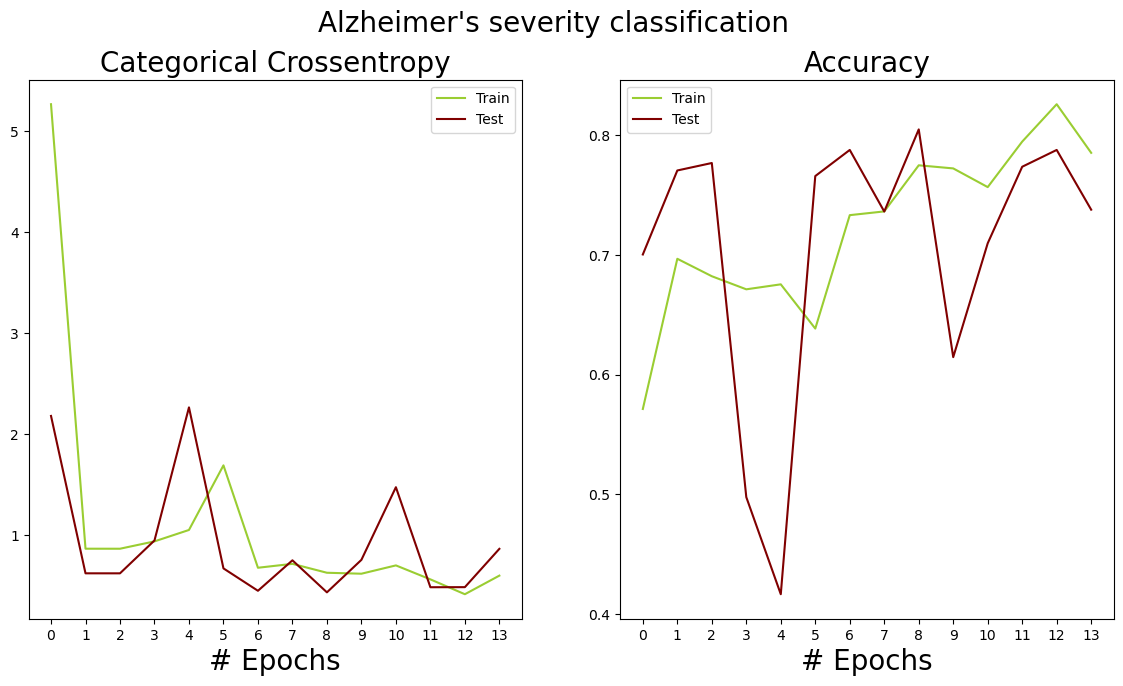

In [65]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_al, 'Alzheimer\'s severity classification')

Accuracy_score: 0.805 



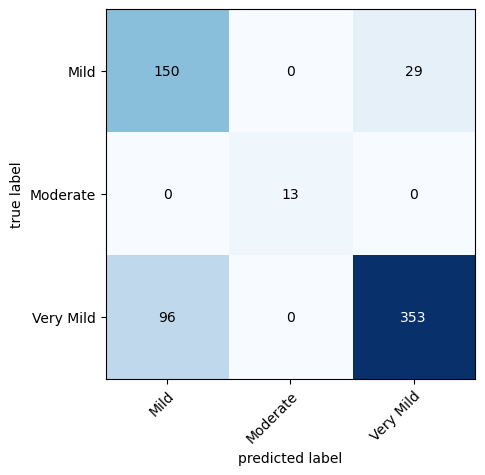

In [66]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_al, X=X_val_al, y=y_val_al, class_names_list = ['Mild', 'Moderate', 'Very Mild'])

Accuracy_score: 0.7261 



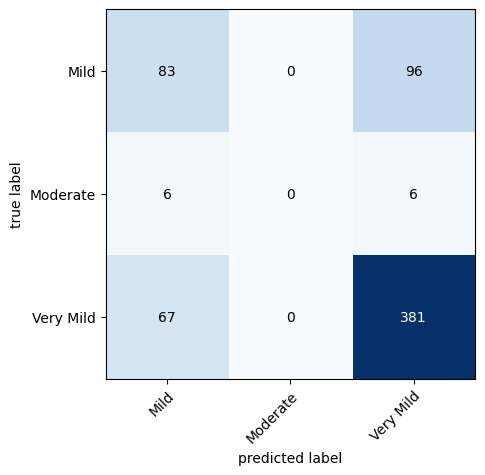

In [67]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_al, X=X_test_al, y=y_test_al, class_names_list = ['Mild', 'Moderate', 'Very Mild'])

In [69]:
model_al.save('../models/model_al.hdf5')

In [12]:
model_al = Sequential()

model_al.add(layers.Input(shape=(image_size, image_size, 1)))

#First Convolution
model_al.add(Conv2D(64, (3,3), activation='relu'))
model_al.add(MaxPooling2D(pool_size=(2,2)))
#Second Convolution
model_al.add(Conv2D(128, (3,3), activation='relu'))
model_al.add(MaxPooling2D(pool_size=(2,2)))
#Third Convolution
model_al.add(Conv2D(64, (3,3), activation='relu'))
model_al.add(MaxPooling2D(pool_size=(2,2)))
#Flatten
model_al.add(Flatten())
# Fully Connected

model_al.add(Dense(64, activation = 'relu'))

model_al.add(Dense(64, activation = 'relu'))

model_al.add(Dense(3, activation='softmax'))

# Compile
model_al.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_al = model_al.fit(X_train_al, y_train_al, validation_data = (X_val_al, y_val_al), epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
60/60 [==============================] - 68s 1s/step - loss: 0.7121 - accuracy: 0.6974 - val_loss: 0.6961 - val_accuracy: 0.7005 - lr: 0.0010
Epoch 2/30
60/60 [==============================] - 71s 1s/step - loss: 0.6771 - accuracy: 0.7000 - val_loss: 0.6545 - val_accuracy: 0.7067 - lr: 0.0010
Epoch 3/30
60/60 [==============================] - 72s 1s/step - loss: 0.5399 - accuracy: 0.7656 - val_loss: 0.4267 - val_accuracy: 0.8222 - lr: 0.0010
Epoch 4/30
60/60 [==============================] - 72s 1s/step - loss: 0.3601 - accuracy: 0.8500 - val_loss: 0.2339 - val_accuracy: 0.9002 - lr: 0.0010
Epoch 5/30
60/60 [==============================] - 72s 1s/step - loss: 0.1638 - accuracy: 0.9344 - val_loss: 0.2107 - val_accuracy: 0.9017 - lr: 0.0010
Epoch 6/30
60/60 [==============================] - 71s 1s/step - loss: 0.0491 - accuracy: 0.9818 - val_loss: 0.0528 - val_accuracy: 0.9766 - lr: 0.0010
Epoch 7/30
60/60 [==============================] - 90s 1s/step - loss: 0.0237 - a

In [13]:
model_al.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 238, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 119, 119, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 117, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 58, 58, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

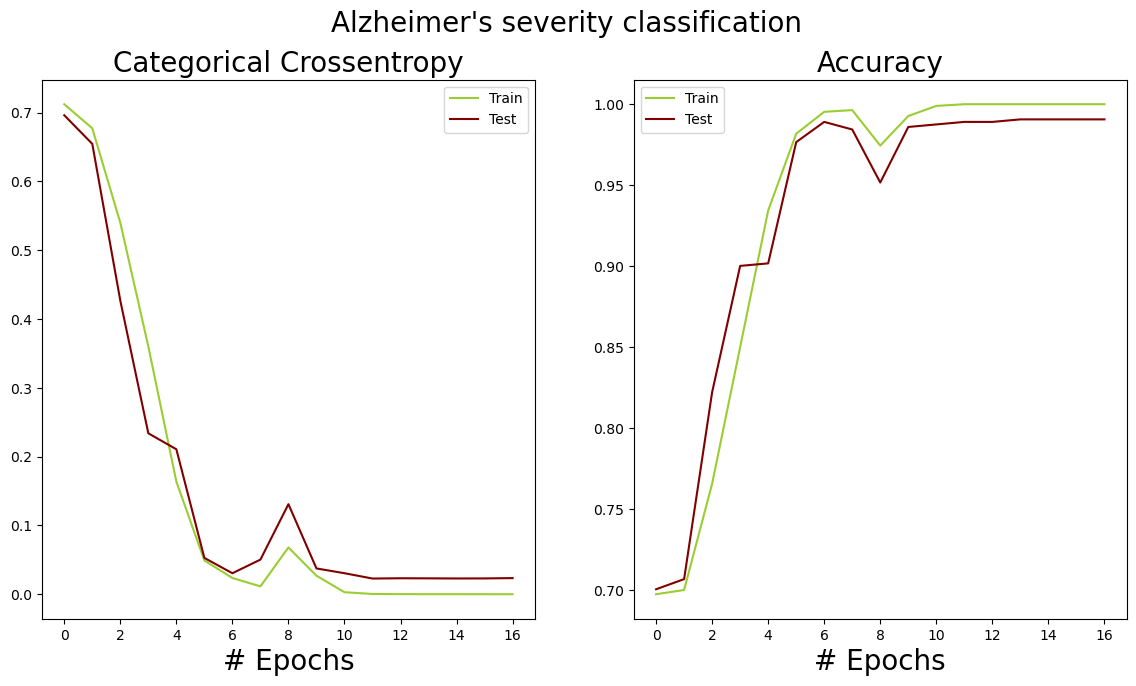

In [15]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_al, 'Alzheimer\'s severity classification')

Accuracy_score: 0.9891 



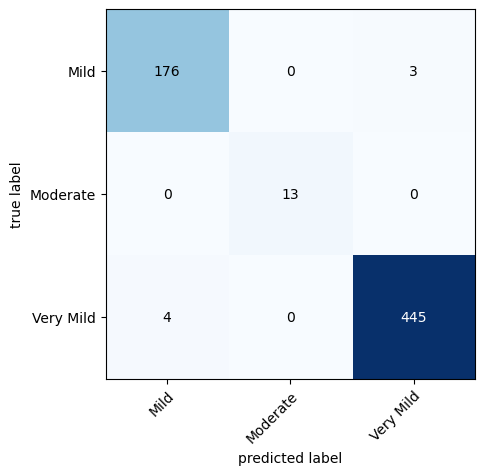

In [16]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_al, X=X_val_al, y=y_val_al, class_names_list = ['Mild', 'Moderate', 'Very Mild'])

Accuracy_score: 0.7684 



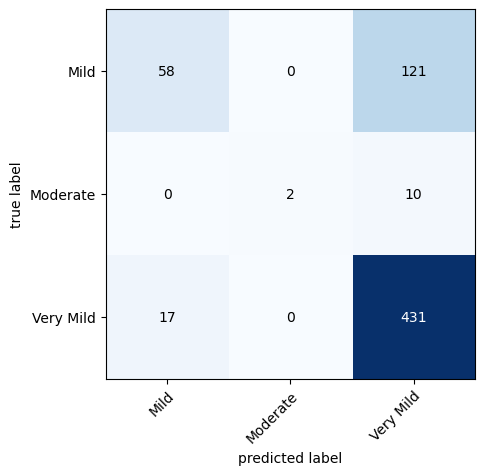

In [14]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_al, X=X_test_al, y=y_test_al, class_names_list = ['Mild', 'Moderate', 'Very Mild'])

In [18]:
#model_al.save('../models/model_al.hdf5')

Accuracy_score: 0.7825 without dropouts and regularization

### Type of Brain Tumor

In [73]:
X_train_bt, X_val_bt, y_train_bt, y_val_bt = load_img_from_dir_cat(bt_path_train)
X_train_bt.shape, y_train_bt.shape

((1856, 240, 240, 3), (1856, 3))

In [74]:
X_test_bt, y_test_bt = load_img_from_dir_cat(bt_path_test)

In [76]:
effnet = EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classes=3,
    classifier_activation="softmax",
    include_preprocessing=True,
)
# Freeze last 5 layers
for layer in effnet.layers[:-5]:
    layer.trainable = False

In [77]:
model_bt = Sequential()

model_bt.add(effnet)
model_bt.add(GlobalAveragePooling2D())
model_bt.add(Dropout(.2))

#Just use a single output layer
model_bt.add(Dense(3, activation='softmax'))

# Compile
model_bt.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_bt = model_bt.fit(X_train_bt, y_train_bt, validation_data = (X_val_bt, y_val_bt), epochs=30, callbacks=[es, reduce_lr])

Epoch 1/30
58/58 [==============================] - 117s 2s/step - loss: 0.9090 - accuracy: 0.5754 - val_loss: 0.7742 - val_accuracy: 0.6688 - lr: 0.0010
Epoch 2/30
58/58 [==============================] - 115s 2s/step - loss: 0.7425 - accuracy: 0.6697 - val_loss: 0.7479 - val_accuracy: 0.6527 - lr: 0.0010
Epoch 3/30
58/58 [==============================] - 111s 2s/step - loss: 0.7228 - accuracy: 0.6584 - val_loss: 0.6576 - val_accuracy: 0.7302 - lr: 0.0010
Epoch 4/30
58/58 [==============================] - 105s 2s/step - loss: 0.6825 - accuracy: 0.6848 - val_loss: 0.8286 - val_accuracy: 0.6527 - lr: 0.0010
Epoch 5/30
58/58 [==============================] - 111s 2s/step - loss: 0.6572 - accuracy: 0.7107 - val_loss: 0.6252 - val_accuracy: 0.7270 - lr: 0.0010
Epoch 6/30
58/58 [==============================] - 111s 2s/step - loss: 0.6265 - accuracy: 0.7101 - val_loss: 0.6035 - val_accuracy: 0.7464 - lr: 0.0010
Epoch 7/30
58/58 [==============================] - 112s 2s/step - loss: 0.6

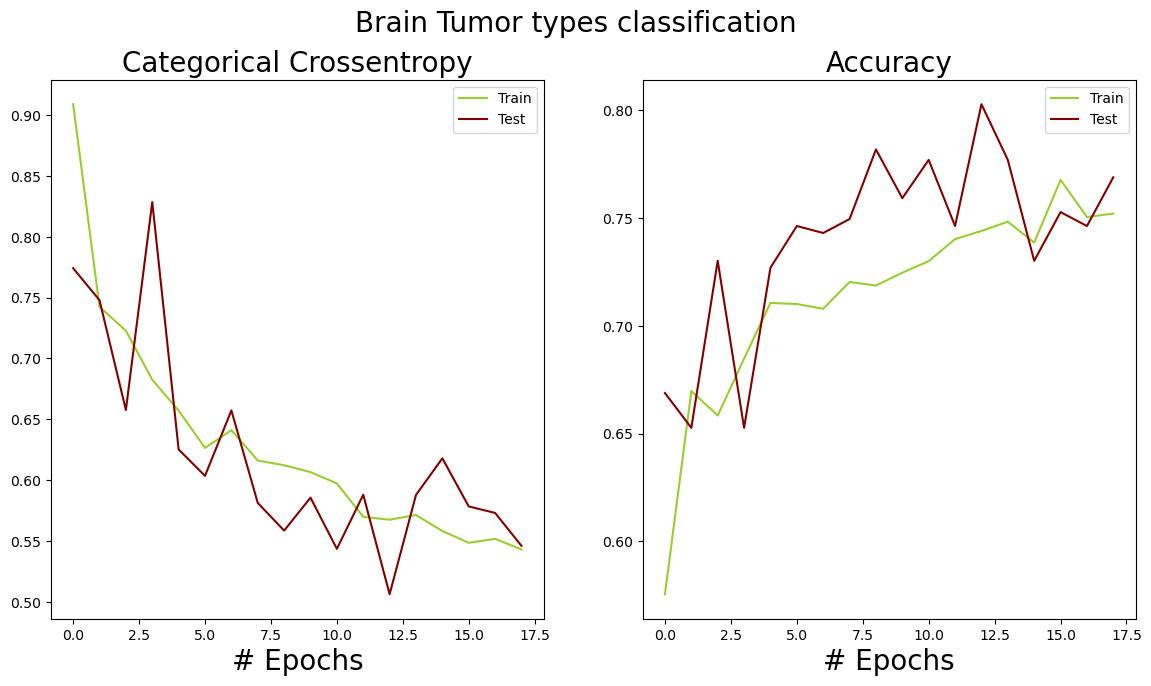

In [78]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_bt, 'Brain Tumor types classification')

Accuracy_score: 0.8029 



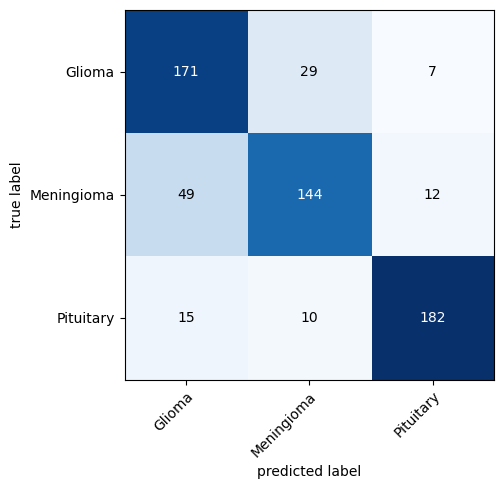

In [79]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_bt, X=X_val_bt, y=y_val_bt, class_names_list = ['Glioma', 'Meningioma', 'Pituitary'])

Accuracy_score: 0.5467 



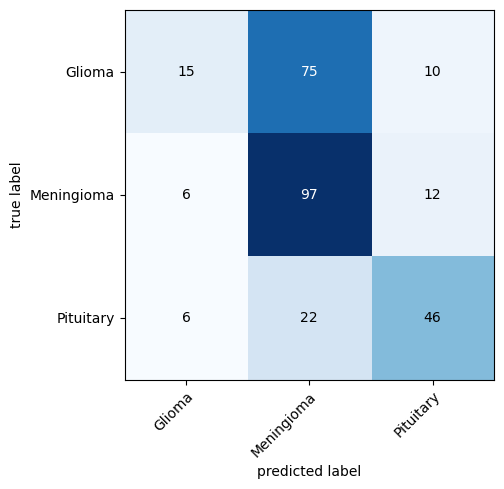

In [80]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_bt, X=X_test_bt, y=y_test_bt, class_names_list = ['Glioma', 'Meningioma', 'Pituitary'])

In [81]:
#model_al.save('../models/model_bt.hdf5')

Tryied adding l2 regularizetion to 0.0005, remove  remove regularizetion -, kernel_regularizer=l2(0.005)

To try:
different Conv2d params
32 - all, different numbers as in bt
removing droupout, , different oprimizers, batch_size 32, 64, Conv2D - 2,2, remove strides (, strides = (2,2) in max pooling), image size 170, pool_size 3,3





Increace droupout

Remove - add one conv layer
Remove - add  one connected layer

In [21]:
model_bt = Sequential()
model_bt.add(layers.Input(shape=(image_size, image_size, 1)))

#First Convolution
model_bt.add(Conv2D(64, (3,3),activation = 'relu'))
model_bt.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
model_bt.add(Dropout(0.2))
#Second Convolution
model_bt.add(Conv2D(64, (2,2),activation = 'relu'))
model_bt.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
model_bt.add(Dropout(0.2))
#Third Convolution
model_bt.add(Conv2D(64, (2,2),activation = 'relu'))
model_bt.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
model_bt.add(Dropout(0.2))
#Fourth Convolution
model_bt.add(Conv2D(64, (2,2),activation = 'relu'))
model_bt.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
model_bt.add(Dropout(0.2))
#Fifth Convolution
model_bt.add(Conv2D(64, (2,2),activation = 'relu'))
model_bt.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
model_bt.add(Dropout(0.2))
#Flatten
model_bt.add(Flatten())
# Fully Connected
model_bt.add(Dropout(0.2))
model_bt.add(Dense(64, activation='relu', kernel_regularizer=l2(0.005)))
model_bt.add(Dropout(0.2))
model_bt.add(Dense(64, activation='relu', kernel_regularizer=l2(0.005)))
model_bt.add(Dropout(0.2))
model_bt.add(Dense(3, activation='softmax'))
# Compile
model_bt.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_bt = model_bt.fit(X_train_bt, y_train_bt, validation_data = (X_val_bt, y_val_bt), epochs=30, callbacks=[es, reduce_lr])

Epoch 1/30
58/58 [==============================] - 106s 2s/step - loss: 1.5349 - accuracy: 0.5059 - val_loss: 1.2691 - val_accuracy: 0.5687 - lr: 0.0010
Epoch 2/30
58/58 [==============================] - 99s 2s/step - loss: 1.0936 - accuracy: 0.6175 - val_loss: 1.0410 - val_accuracy: 0.6801 - lr: 0.0010
Epoch 3/30
58/58 [==============================] - 102s 2s/step - loss: 0.9217 - accuracy: 0.7031 - val_loss: 0.8654 - val_accuracy: 0.7076 - lr: 0.0010
Epoch 4/30
58/58 [==============================] - 102s 2s/step - loss: 0.8712 - accuracy: 0.7047 - val_loss: 0.8469 - val_accuracy: 0.7351 - lr: 0.0010
Epoch 5/30
58/58 [==============================] - 104s 2s/step - loss: 0.7425 - accuracy: 0.7586 - val_loss: 0.7042 - val_accuracy: 0.7900 - lr: 0.0010
Epoch 6/30
58/58 [==============================] - 101s 2s/step - loss: 0.6807 - accuracy: 0.7823 - val_loss: 0.6752 - val_accuracy: 0.8110 - lr: 0.0010
Epoch 7/30
58/58 [==============================] - 102s 2s/step - loss: 0.65

Accuracy_score: 0.6471 



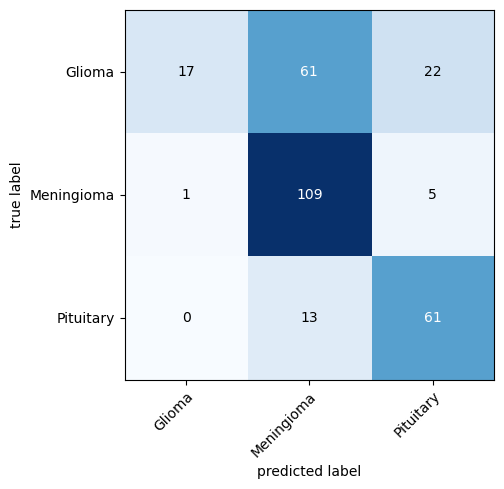

In [22]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_bt, X=X_test_bt, y=y_test_bt, class_names_list = ['Glioma', 'Meningioma', 'Pituitary'])

In [28]:
model_bt.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 239, 239, 64)      320       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 119, 119, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 118, 118, 64)      16448     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 59, 59, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 58, 58, 128)       32896     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 29, 29, 128)     

## Best so far

In [134]:
from keras.optimizers import Adam

learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)


from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)


In [ ]:
model_bt = Sequential()
model_bt.add(layers.Input(shape=(image_size, image_size, 1)))

#First Convolution
model_bt.add(Conv2D(64, (2,2),activation = 'relu'))
model_bt.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Second Convolution
model_bt.add(Conv2D(64, (2,2),activation = 'relu'))
model_bt.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Third Convolution
model_bt.add(Conv2D(128, (2,2),activation = 'relu'))
model_bt.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Fourth Convolution
model_bt.add(Conv2D(256, (2,2),activation = 'relu'))
model_bt.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Fifth Convolution
model_bt.add(Conv2D(512, (2,2),activation = 'relu'))
model_bt.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))
#Flatten
model_bt.add(Flatten())
# Fully Connected
model_bt.add(Dropout(0.2))
model_bt.add(Dense(256, activation='relu', kernel_regularizer=l2(0.005)))
model_bt.add(Dropout(0.2))
model_bt.add(Dense(128, activation='relu', kernel_regularizer=l2(0.005)))
model_bt.add(Dropout(0.2))
model_bt.add(Dense(3, activation='softmax'))
# Compile
model_bt.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_bt = model_bt.fit(X_train_bt, y_train_bt, validation_data = (X_val_bt, y_val_bt), epochs=25, callbacks=[es, reduce_lr])

Epoch 1/25
58/58 [==============================] - 47s 800ms/step - loss: 1.8524 - accuracy: 0.5792 - val_loss: 1.2314 - val_accuracy: 0.6317 - lr: 2.0000e-04
Epoch 2/25
58/58 [==============================] - 47s 810ms/step - loss: 1.0431 - accuracy: 0.6923 - val_loss: 1.0073 - val_accuracy: 0.6947 - lr: 2.0000e-04
Epoch 3/25
58/58 [==============================] - 46s 803ms/step - loss: 0.8699 - accuracy: 0.7489 - val_loss: 0.7794 - val_accuracy: 0.8045 - lr: 2.0000e-04
Epoch 4/25
58/58 [==============================] - 47s 804ms/step - loss: 0.7337 - accuracy: 0.8098 - val_loss: 0.6610 - val_accuracy: 0.8595 - lr: 2.0000e-04
Epoch 5/25
58/58 [==============================] - 47s 805ms/step - loss: 0.6218 - accuracy: 0.8578 - val_loss: 0.6320 - val_accuracy: 0.8384 - lr: 2.0000e-04
Epoch 6/25
58/58 [==============================] - 48s 827ms/step - loss: 0.5735 - accuracy: 0.8728 - val_loss: 0.5770 - val_accuracy: 0.8708 - lr: 2.0000e-04
Epoch 7/25
58/58 [======================

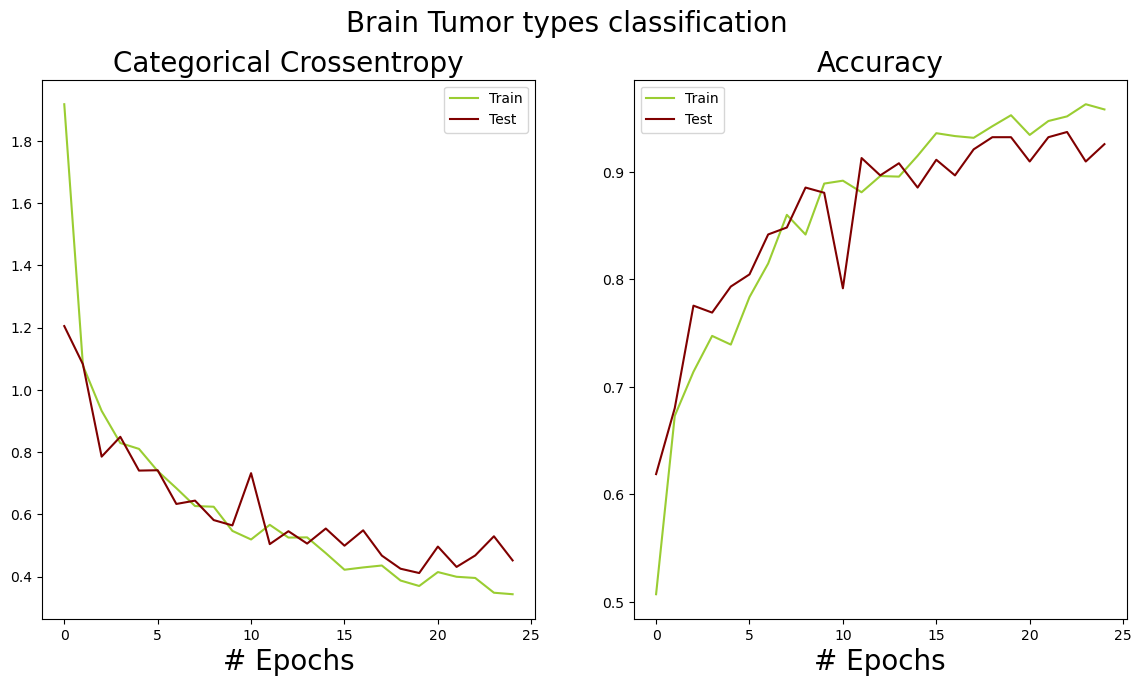

In [97]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_bt, 'Brain Tumor types classification')

Accuracy_score: 0.9321 



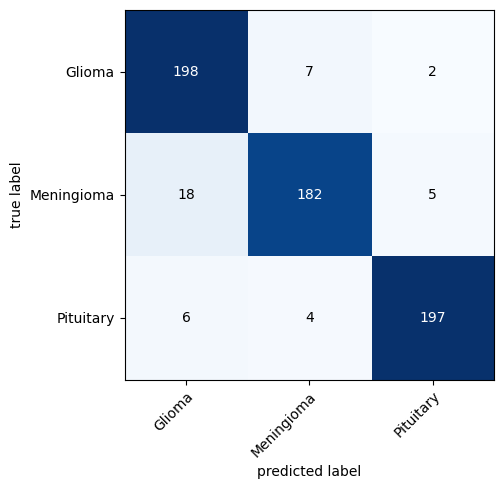

In [98]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_bt, X=X_val_bt, y=y_val_bt, class_names_list = ['Glioma', 'Meningioma', 'Pituitary'])

Accuracy_score: 0.6782 



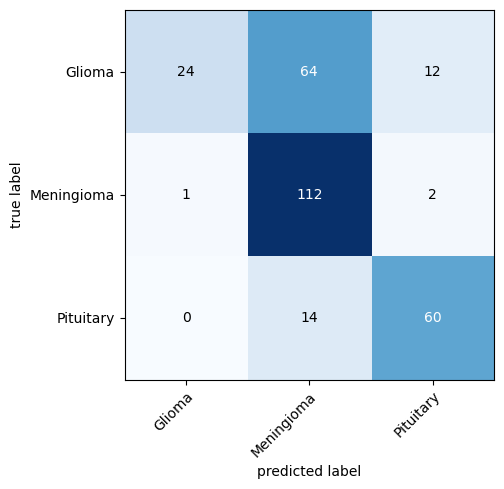

In [96]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_bt, X=X_test_bt, y=y_test_bt, class_names_list = ['Glioma', 'Meningioma', 'Pituitary'])

## Combine all to classify a single input image

In [ ]:
def predict_image(image_path):
    test_img = img_to_array(load_img(image_path))
    test_img = smart_resize(test_img, (image_size, image_size))
    test_img = np.expand_dims(test_img, axis=0)
    predicted_dis_no_dis = model.predict(test_img)
    if predicted_dis_no_dis == 0:
        return 'No disease found in MRI'
    else:
        predict_al_bt = model_al_bt.predict(test_img)########################
        if predict_al_bt == 0:
            predict_al = model_al.predict(test_img)
            al_list = ['Mild', 'Moderate', 'Very Mild']
            return al_list[predict_al]
        else:
            predict_bt = model_bt.predict(test_img)
            bt_list = ['Glioma', 'Meningioma', 'Pituitary']
            return bt_list[predict_bt]

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize
import numpy as np


image_path = '../data/brain_tumor/test/meningioma_tumor/image(2).jpg'

image_size = 240

test_img = img_to_array(load_img(image_path, color_mode = "grayscale"))
test_img = smart_resize(test_img, (image_size, image_size))
test_img = np.expand_dims(test_img, axis=0)

test_img.shape